# Customer Review Analysis


Berikut adalah analisa Olist's E-Commerce dataset dari customer reviews. 

### Data Exploration

In [4]:
import random
from PIL import Image
from datetime import datetime
import unicodedata
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
import warnings
import seaborn as sns
import nltk
warnings.filterwarnings('ignore')
import matplotlib as mpl
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
mpl.rc('font', family='Calibri')
mpl.rc('axes', unicode_minus=False)
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

COLOR_5S = '#0571b0'
COLOR_1S = '#ca0020'
REVIEWS_PALETTE = sns.color_palette((COLOR_1S, '#d57b6f', '#c6c6c6', '#7f9abc', COLOR_5S))

In [6]:
data = pd.read_csv('data/olist_order_reviews_dataset.csv')
data.head()

review_id                          order_id  \
0  7bc2406110b926393aa56f80a40eba40  73fc7af87114b39712e6da79b0a377eb   
1  80e641a11e56f04c1ad469d5645fdfde  a548910a1c6147796b98fdf73dbeba33   
2  228ce5500dc1d8e020d8d1322874b6f0  f9e4b658b201a9f2ecdecbb34bed034b   
3  e64fb393e7b32834bb789ff8bb30750e  658677c97b385a9be170737859d3511b   
4  f7c4243c7fe1938f181bec41a392bdeb  8e6bfb81e283fa7e4f11123a3fb894f1   

   review_score review_comment_title  \
0             4                  NaN   
1             5                  NaN   
2             5                  NaN   
3             5                  NaN   
4             5                  NaN   

                              review_comment_message review_creation_date  \
0                                                NaN  2018-01-18 00:00:00   
1                                                NaN  2018-03-10 00:00:00   
2                                                NaN  2018-02-17 00:00:00   
3              Recebi bem antes do prazo estipulado.  2017-04-21 00:00:00   
4  Parabéns lojas lannister adorei comprar pela I...  2018-03-01 00:00:00   

  review_answer_timestamp  
0     2018-01-18 21:46:59  
1     2018-03-11 03:05:13  
2     2018-02-18 14:36:24  
3     2017-04-21 22:02:06  
4     2018-03-02 10:26:53

In [7]:
data['review_comment_length'] = data['review_comment_message'].str.len()
data.head()

review_id                          order_id  \
0  7bc2406110b926393aa56f80a40eba40  73fc7af87114b39712e6da79b0a377eb   
1  80e641a11e56f04c1ad469d5645fdfde  a548910a1c6147796b98fdf73dbeba33   
2  228ce5500dc1d8e020d8d1322874b6f0  f9e4b658b201a9f2ecdecbb34bed034b   
3  e64fb393e7b32834bb789ff8bb30750e  658677c97b385a9be170737859d3511b   
4  f7c4243c7fe1938f181bec41a392bdeb  8e6bfb81e283fa7e4f11123a3fb894f1   

   review_score review_comment_title  \
0             4                  NaN   
1             5                  NaN   
2             5                  NaN   
3             5                  NaN   
4             5                  NaN   

                              review_comment_message review_creation_date  \
0                                                NaN  2018-01-18 00:00:00   
1                                                NaN  2018-03-10 00:00:00   
2                                                NaN  2018-02-17 00:00:00   
3              Recebi bem antes do prazo estipulado.  2017-04-21 00:00:00   
4  Parabéns lojas lannister adorei comprar pela I...  2018-03-01 00:00:00   

  review_answer_timestamp  review_comment_length  
0     2018-01-18 21:46:59                    NaN  
1     2018-03-11 03:05:13                    NaN  
2     2018-02-18 14:36:24                    NaN  
3     2017-04-21 22:02:06                   37.0  
4     2018-03-02 10:26:53                  100.0

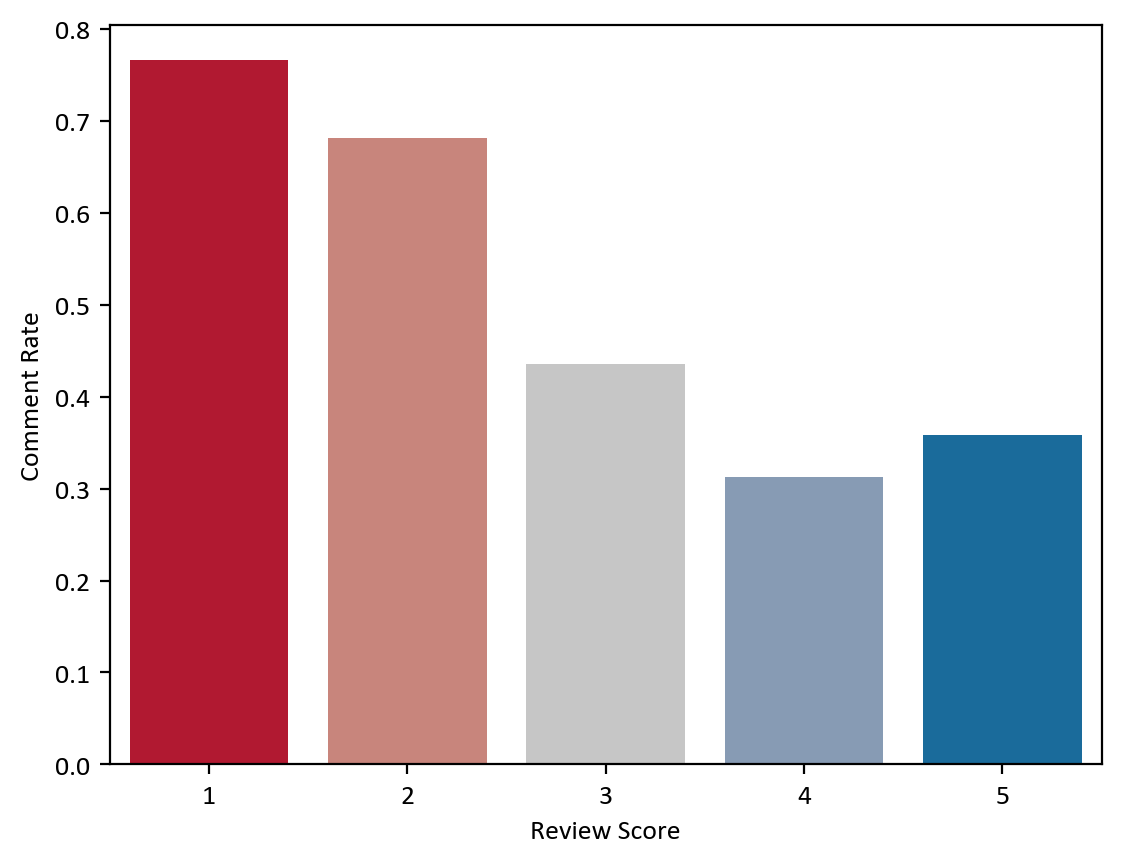

In [27]:
def comment_rate(df):
    return df['review_comment_length'].count() / len(df)

comment_rates = data.groupby('review_score').apply(comment_rate)
sns.barplot(
    x=comment_rates.index, 
    y=comment_rates.values, 
    palette=REVIEWS_PALETTE
).set(xlabel='Review Score', ylabel='Comment Rate');


Tampaknya pelanggan yang tidak puas lebih cenderung menulis komentar.

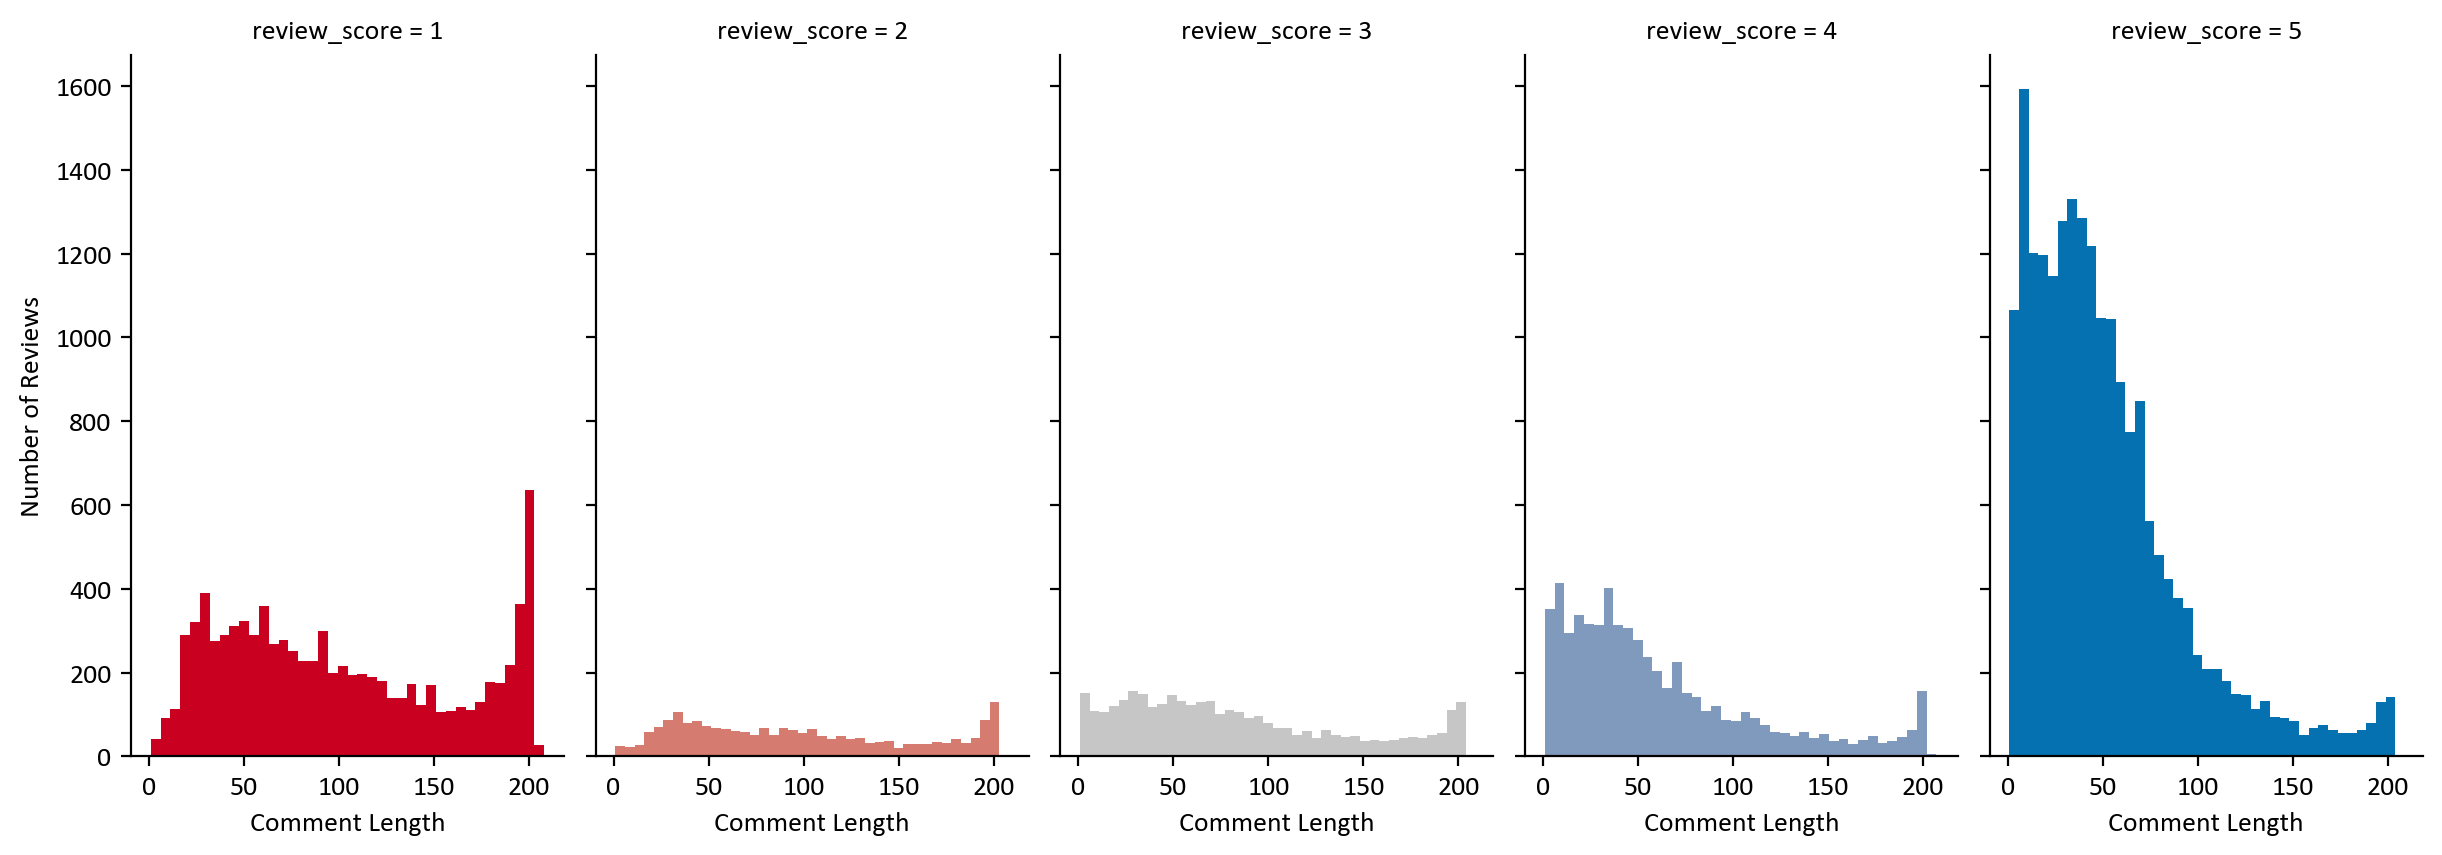

In [28]:
g = sns.FacetGrid(data=data, col='review_score', hue='review_score', palette=REVIEWS_PALETTE)
g.map(plt.hist, 'review_comment_length', bins=40)
g.set_xlabels('Comment Length')
g.set_ylabels('Number of Reviews')
plt.gcf().set_size_inches(12, 5)

In [29]:
data = data[['review_comment_message', 'review_score', 'review_comment_length']].dropna()
data.head()

review_comment_message  review_score  \
3               Recebi bem antes do prazo estipulado.             5   
4   Parabéns lojas lannister adorei comprar pela I...             5   
9   aparelho eficiente. no site a marca do aparelh...             4   
12    Mas um pouco ,travando...pelo valor ta Boa.\r\n             4   
15  Vendedor confiável, produto ok e entrega antes...             5   

    review_comment_length  
3                    37.0  
4                   100.0  
9                   174.0  
12                   45.0  
15                   56.0

<Axes: xlabel='review_score', ylabel='review_comment_length'>

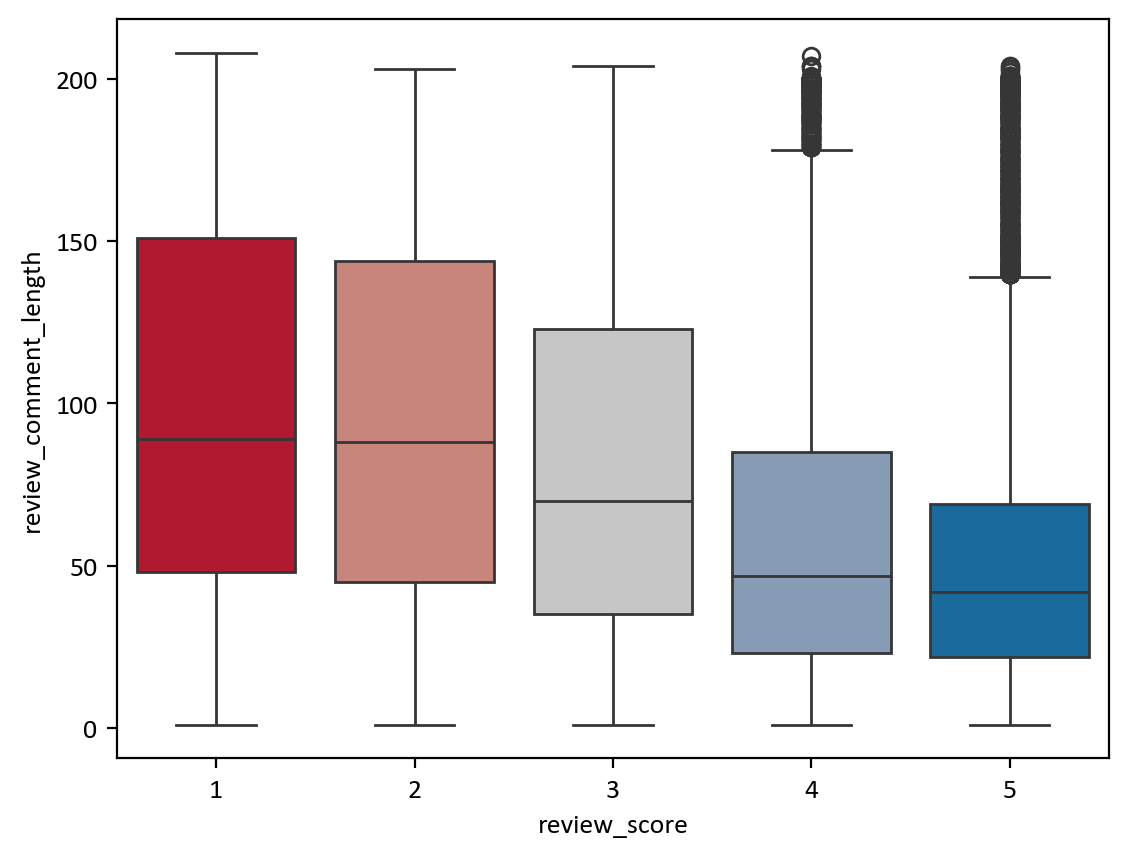

In [30]:
sns.boxplot(x='review_score', y='review_comment_length', data=data, palette=REVIEWS_PALETTE)

Review scores buruk lebih memiliki kalimat komentar yang lebih panjang

## Natural Language Processing

In [42]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [43]:
def remove_accents(text):
    return unicodedata.normalize('NFKD', text).encode('ascii', errors='ignore').decode('utf-8')

STOP_WORDS = set(remove_accents(w) for w in nltk.corpus.stopwords.words('portuguese'))
STOP_WORDS.remove('nao') # This word is key to understand delivery problems later


def comments_to_words(comment):
    lowered = comment.lower()
    normalized = remove_accents(lowered)
    tokens = nltk.tokenize.word_tokenize(normalized)
    words = tuple(t for t in tokens if t not in STOP_WORDS and t.isalpha())
    return words

def words_to_ngrams(words):
    unigrams, bigrams, trigrams = [], [], []
    for comment_words in words:
        unigrams.extend(comment_words)
        bigrams.extend(' '.join(bigram) for bigram in nltk.bigrams(comment_words))
        trigrams.extend(' '.join(trigram) for trigram in nltk.trigrams(comment_words))
    
    return unigrams, bigrams, trigrams

def plot_freq(tokens, color):
    nltk.FreqDist(tokens).plot(25, cumulative=False, color=color)


In [45]:
commented_reviews = data.copy()
commented_reviews['review_comment_words'] = commented_reviews['review_comment_message'].apply(comments_to_words)

reviews_5s = commented_reviews[commented_reviews['review_score'] == 5]
reviews_1s = commented_reviews[commented_reviews['review_score'] == 1]

unigrams_5s, bigrams_5s, trigrams_5s = words_to_ngrams(reviews_5s['review_comment_words'])
unigrams_1s, bigrams_1s, trigrams_1s = words_to_ngrams(reviews_1s['review_comment_words'])

### Review Comments (Review Score=5)

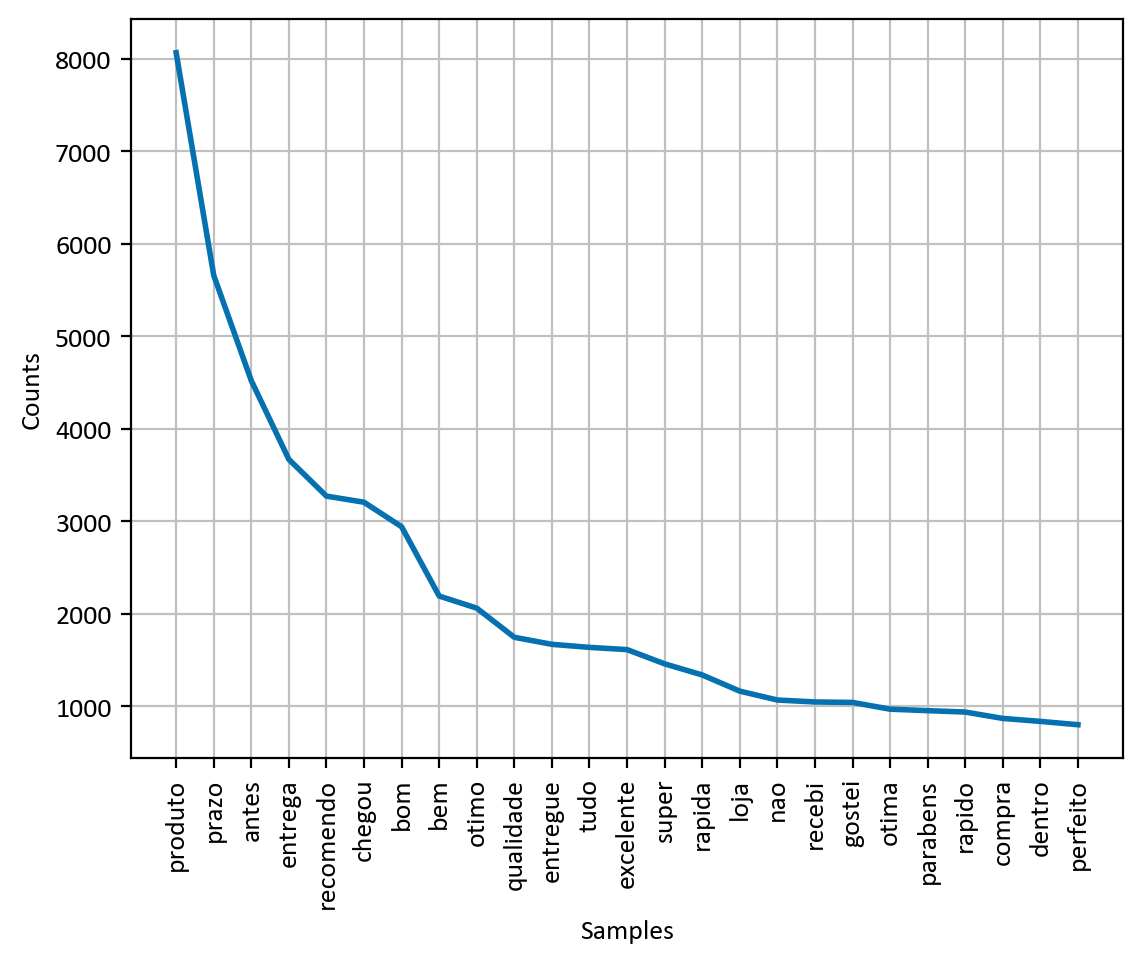

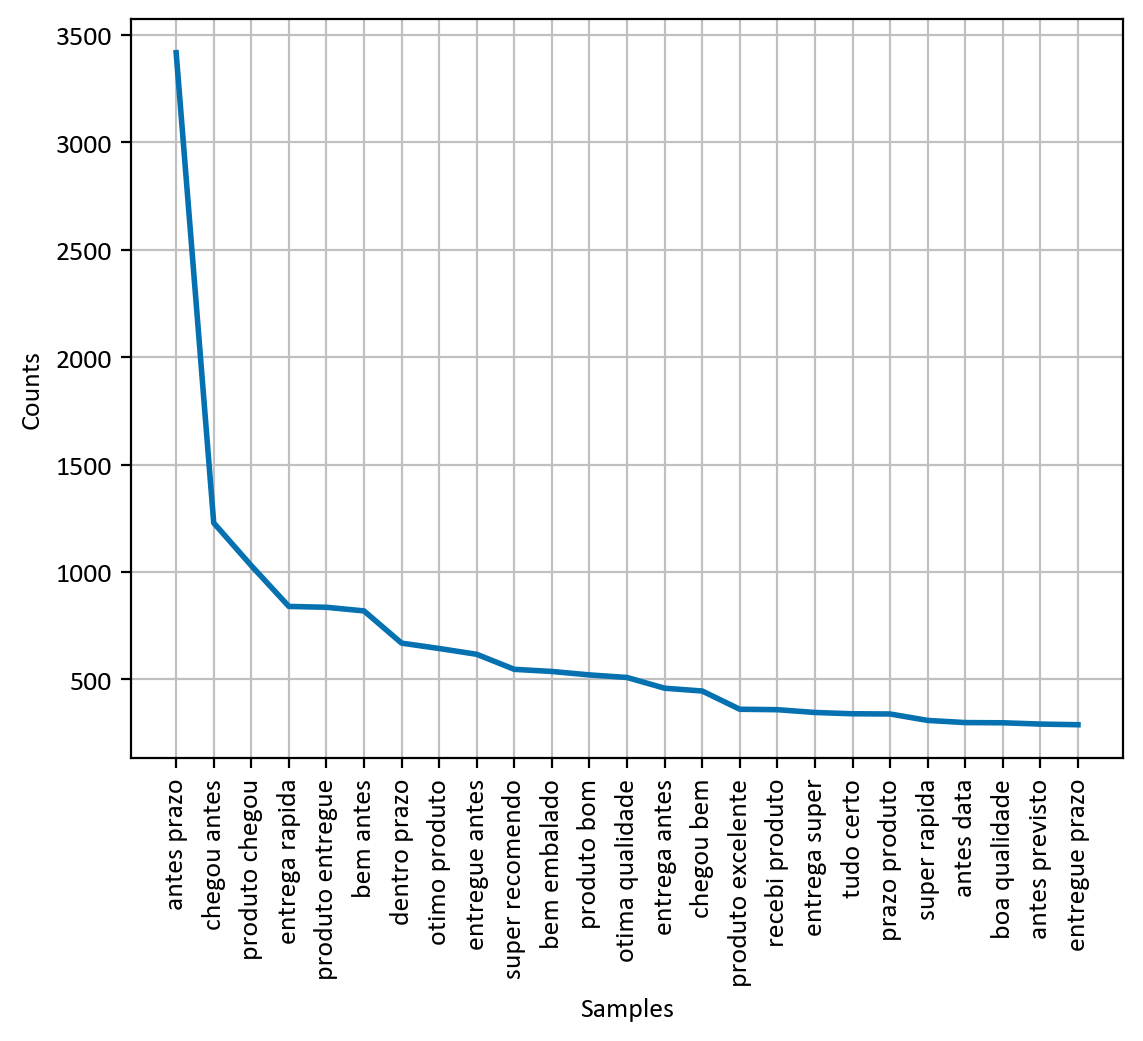

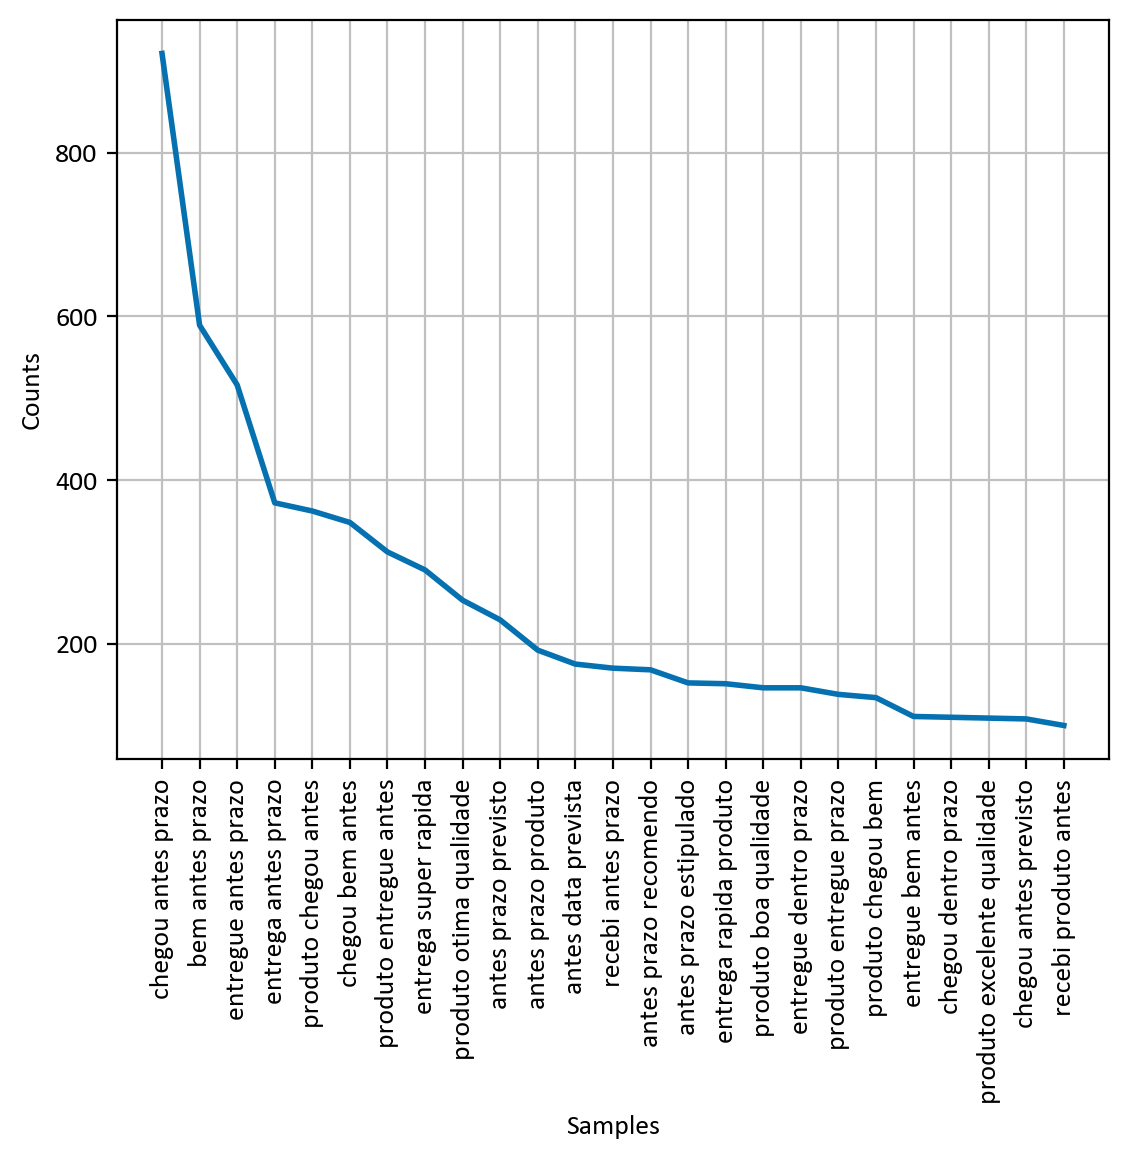

In [46]:
plot_freq(unigrams_5s, COLOR_5S)
plot_freq(bigrams_5s, COLOR_5S)
plot_freq(trigrams_5s, COLOR_5S)

Pelanggan Olist (skor ulasan = 5) menikmati pengalaman mereka:
- Pengiriman cepat (`chegou antes prazo`, `entrega rapida`, `entregue antes prazo`, `super rapida`)
- Barang berkualitas tinggi (`produto otima qualidade`, `otimo produto`, `produto excelente`, `produto boa qualidade`)
- Kemasan yang baik (`bem embalado`, `produto chegou bem`)em')

### Review Comments (Review Score=1)

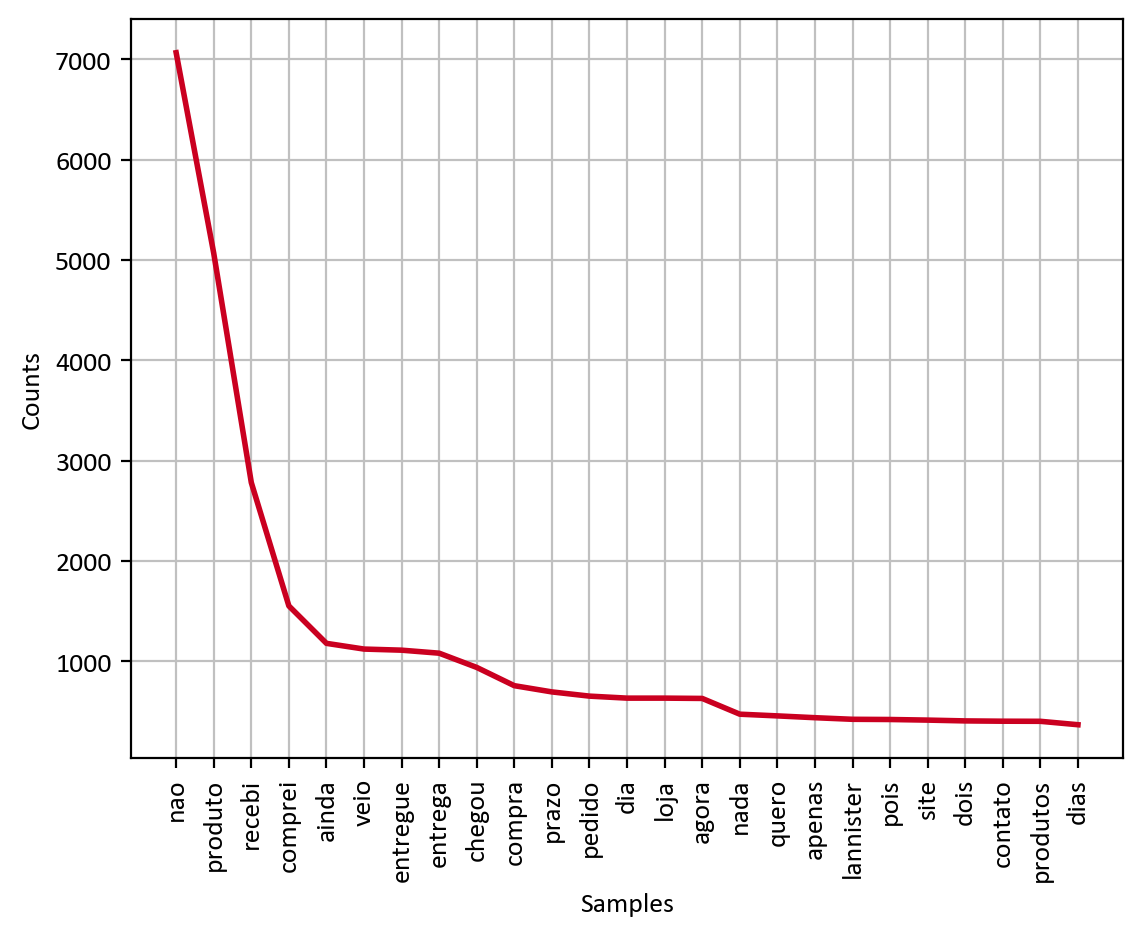

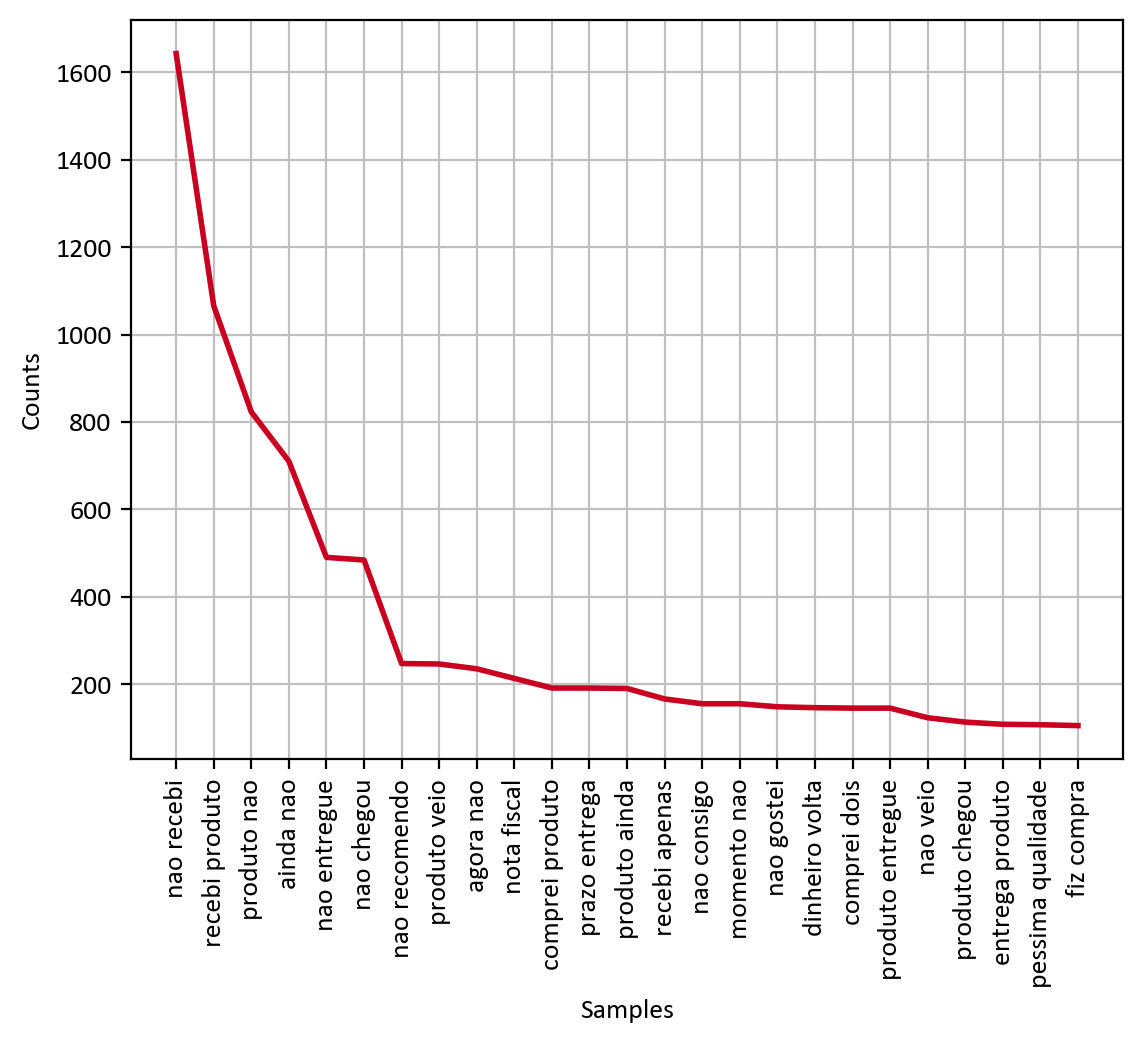

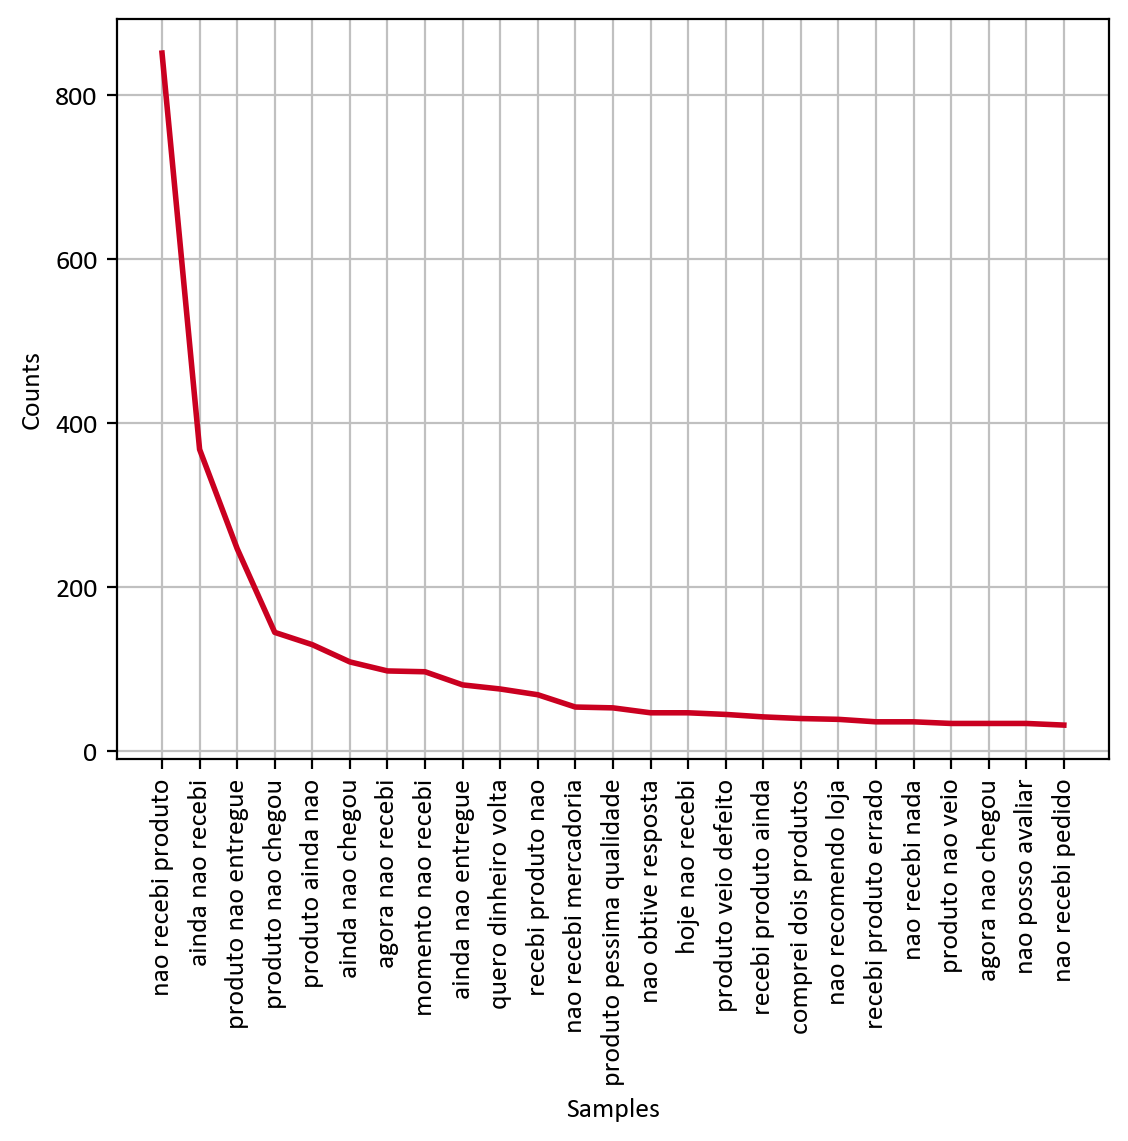

In [47]:
plot_freq(unigrams_1s, COLOR_1S)
plot_freq(bigrams_1s, COLOR_1S)
plot_freq(trigrams_1s, COLOR_1S)

Pelanggan Olist (skor ulasan = 1) merasa tidak puas dengan pengalaman mereka:
- Mereka menerima barang yang salah ('recebi produto errado', 'produto veio errado', 'produto totalmente diferente')
- Beberapa pelanggan menerima barang palsu ('produto nao original')
- Orang-orang menilai layanan pelanggan penjual buruk, yang terlihat tidak responsif dalam beberapa kasus
- Beberapa orang tidak menerima faktur merekamereka

## Clustering Customer Comments

### Vectorization

Gunakan metode Tf-idf 

In [48]:
review = data[['review_comment_message']].copy()
review.head()

review_comment_message
3               Recebi bem antes do prazo estipulado.
4   Parabéns lojas lannister adorei comprar pela I...
9   aparelho eficiente. no site a marca do aparelh...
12    Mas um pouco ,travando...pelo valor ta Boa.\r\n
15  Vendedor confiável, produto ok e entrega antes...

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=100, ngram_range=(2, 4), stop_words=stopwords.words('portuguese'))
vectorizer.fit(review['review_comment_message'])
X = vectorizer.transform(review['review_comment_message'])

### Dimensionality reduction


Karena banyak fitur, mari gunakan PCA (Analisis Komponen Utama) untuk mengurangi dimensi.

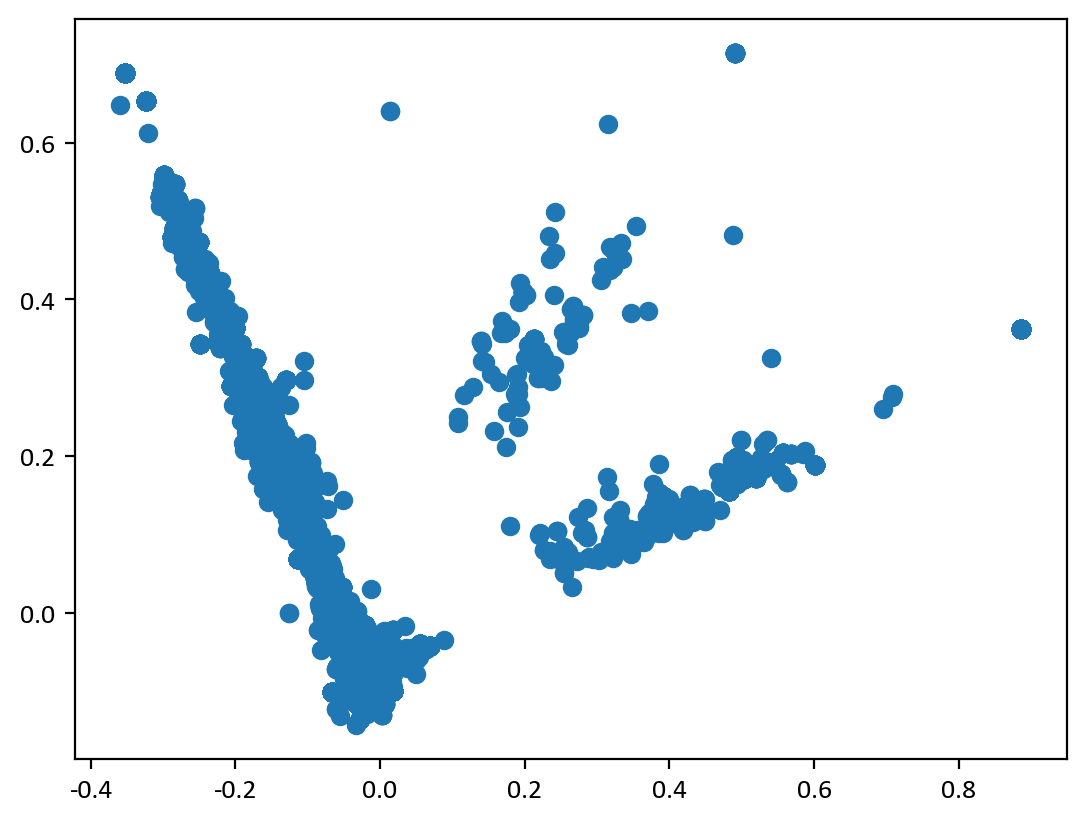

In [50]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
pca.fit(X.toarray())
X_pca = pca.transform(X.toarray())
plt.scatter(X_pca[:,0], X_pca[:,1])

### Clustering

Karena terdapat banyak fitur, mari gunakan PCA (Principal Component Analysis) untuk mengurangi dimensi.

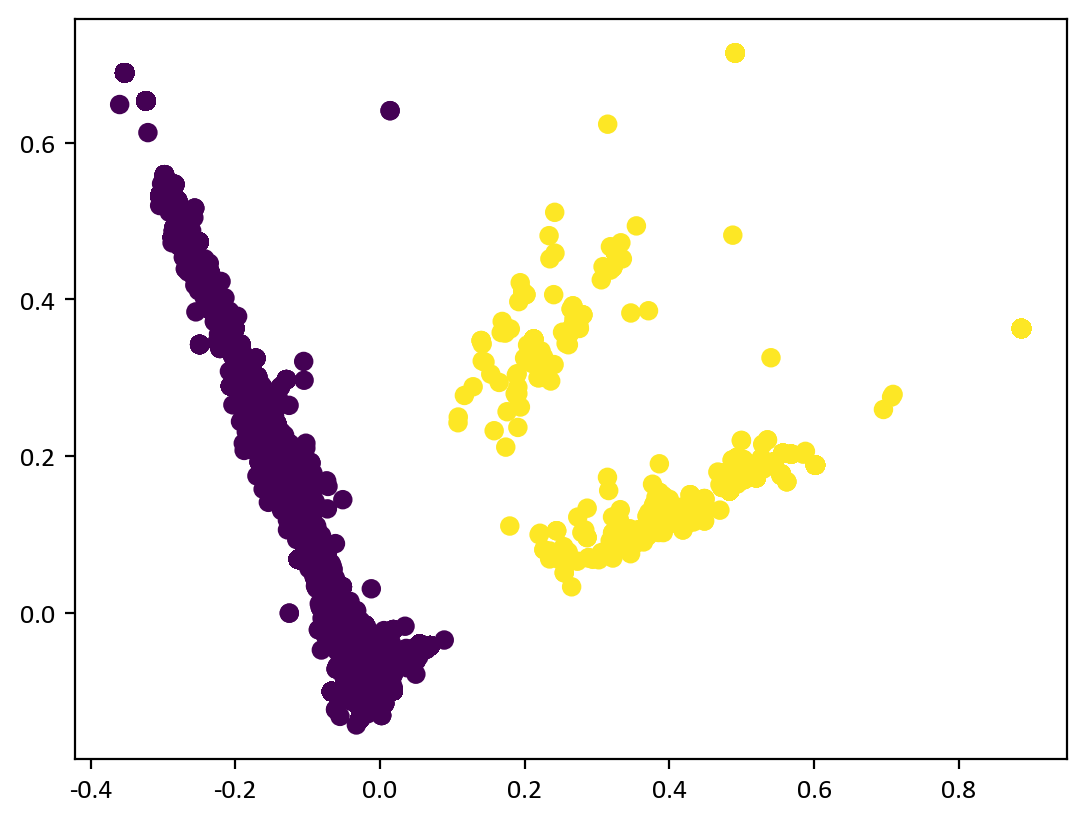

In [51]:
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(n_clusters=2)
predicted = model.fit_predict(X_pca)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=predicted)

In [52]:
review['predicted'] = predicted
review['predicted'].value_counts()

predicted
0    39116
1     1861
Name: count, dtype: int64

([<matplotlib.axis.XTick at 0x2837624c680>,
 [Text(0, 0, '1'), Text(1, 0, '2')])

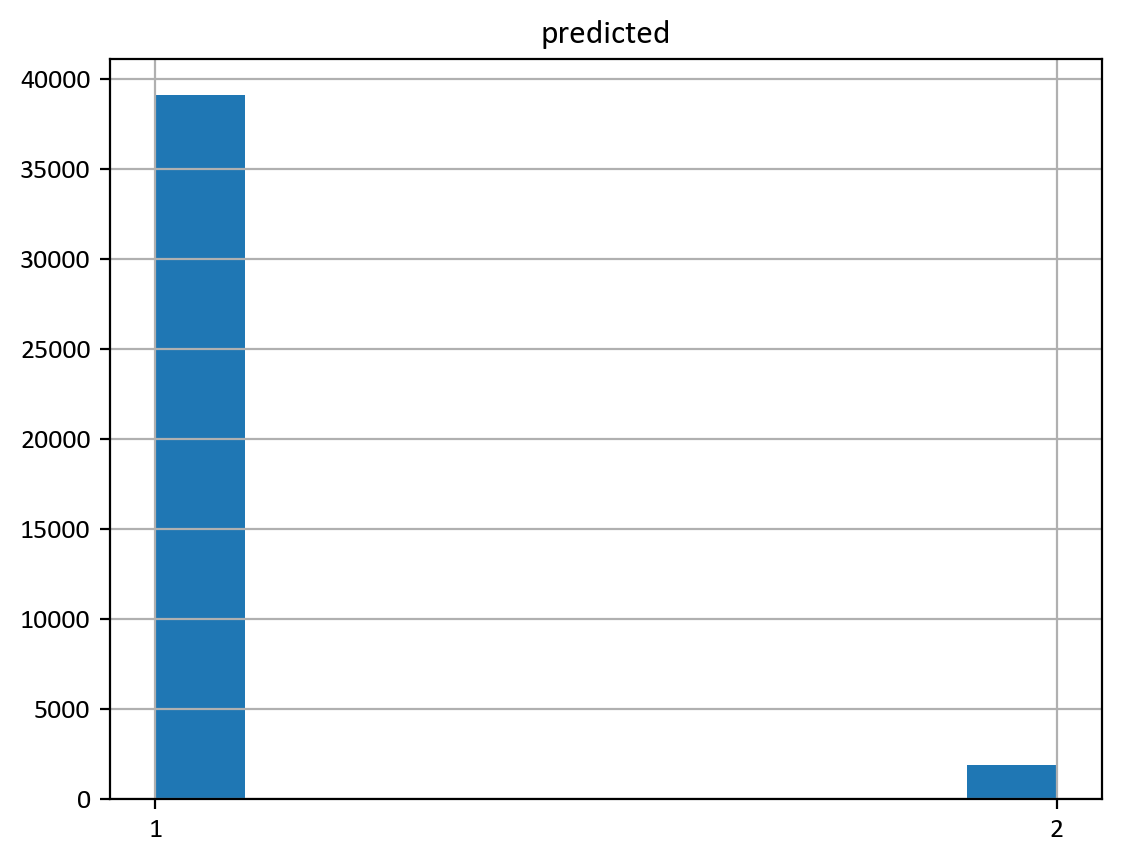

In [53]:
review[['predicted']].hist()
plt.xticks(np.arange(2), np.arange(1, 3))

### Word Clouds of the Clusters

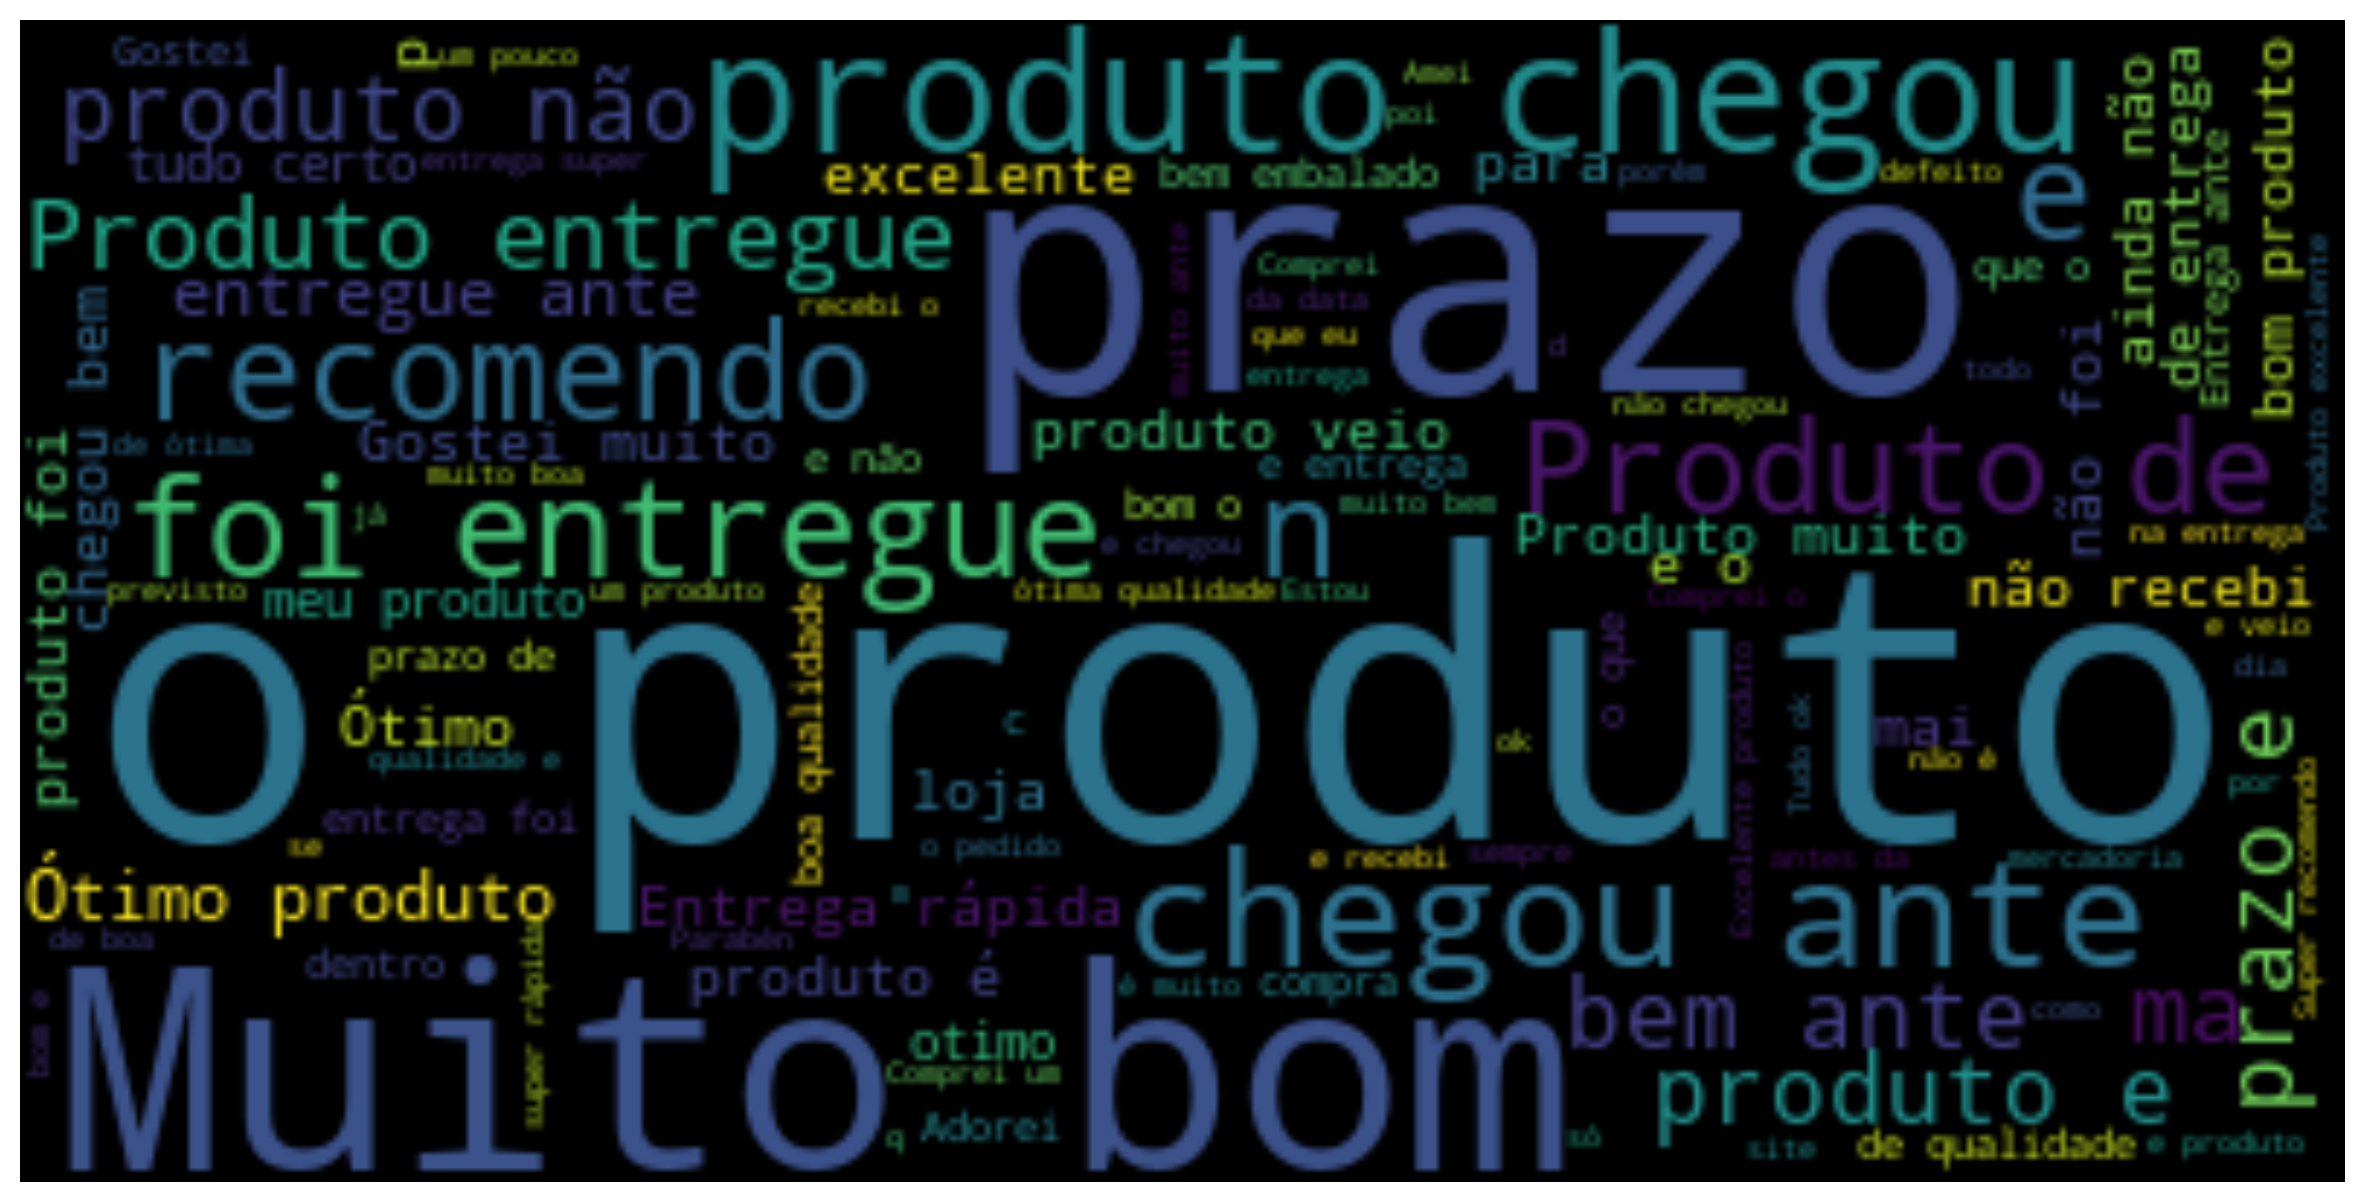

In [54]:
text = review[review['predicted'] == 0]['review_comment_message'].to_string()

wordcloud = WordCloud().generate(text)
plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off");

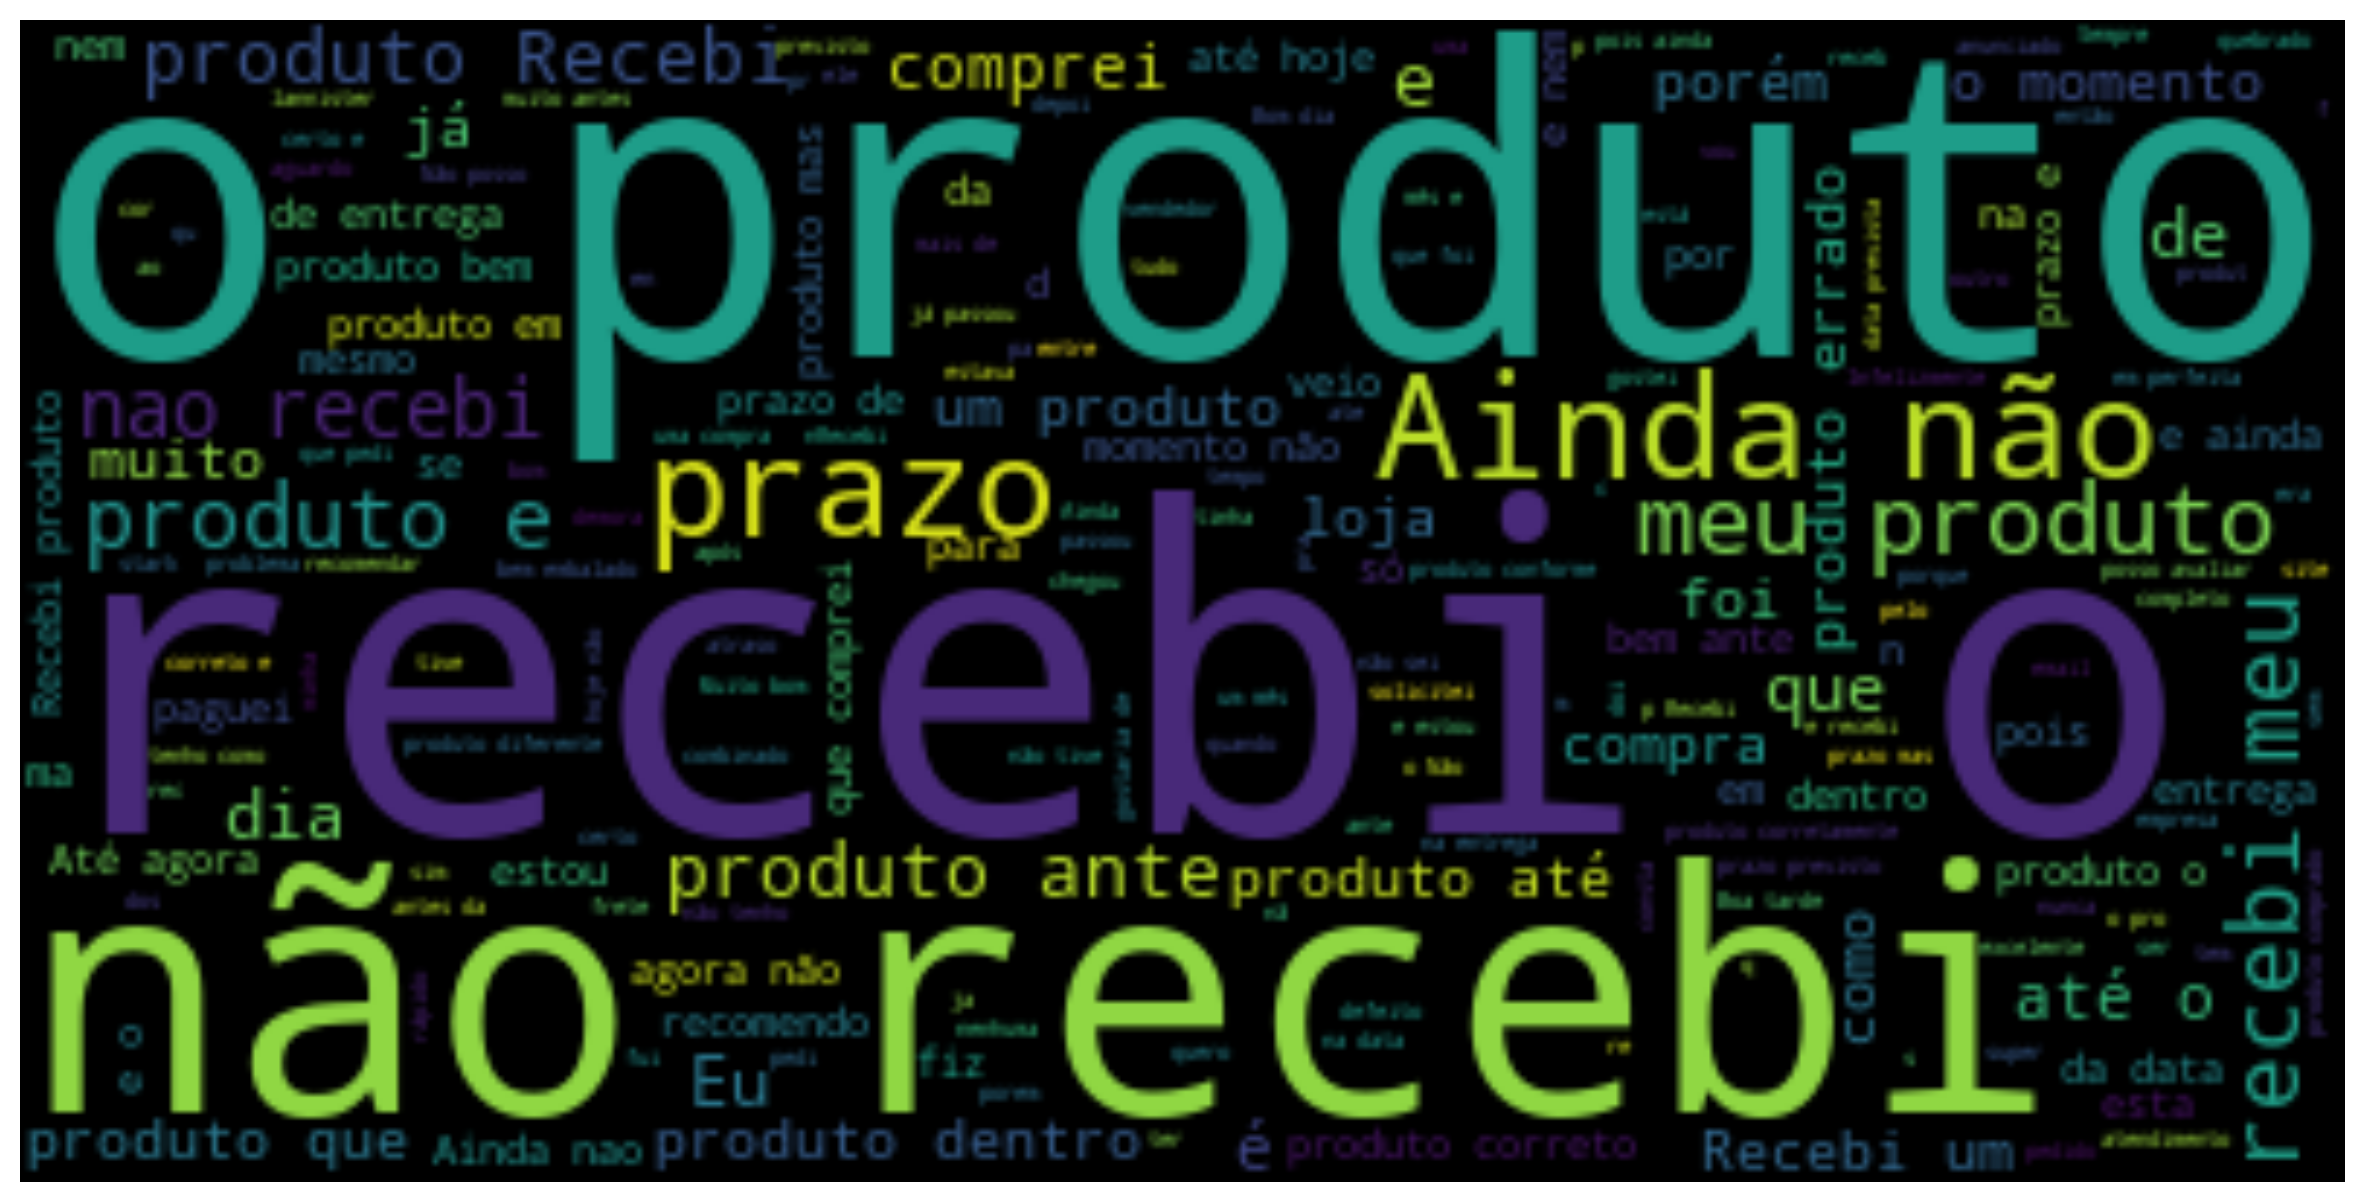

In [55]:
text = review[review['predicted'] == 1]['review_comment_message'].to_string()

wordcloud = WordCloud().generate(text)
plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off");

Melihat dari awan kata-kata, kita dapat melihat bahwa waktu pengiriman sangat penting bagi pelanggan. Kelompok pertama terlihat seperti ulasan yang bagus yang menunjukkan pujian dan kepuasan terutama terkait dengan pengiriman produk yang lebih awal. Di sisi lain, kelompok kedua menunjukkan ketidakpuasan tentang keterlambatan pengiriman dan dalam beberapa kasus pengiriman produk yang salah tetap menjadi mayoritas.

Ini menunjukkan bahwa pengiriman adalah sesuatu yang harus diperhatikan penjual dengan ekstra, selalu mencari pengangkut yang memiliki tingkat keterlambatan yang rendah dan dalam kebanyakan kasus pengiriman lebih awal dari perkiraan.